In [72]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, when,split,col,mean, stddev
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [73]:
spark = SparkSession.builder \
    .appName("Passing Rate Analysis") \
    .getOrCreate()


passes_df = spark.read.csv("passes.csv", header=True, inferSchema=True, sep=";")

passes_df.show(5)

+-------+-------------+------+
|game_id|passing_quote|winner|
+-------+-------------+------+
|     11|           72|    No|
|     11|           91|   Yes|
|     12|           82|   Yes|
|     12|           86|    No|
|     13|           82|   Yes|
+-------+-------------+------+
only showing top 5 rows



In [74]:
passes_df.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- passing_quote: string (nullable = true)
 |-- winner: string (nullable = true)



In [75]:
#In the dataset, passing_quote is a string and we need to convert it to integer
#And winner is a string and we need to convert it to boolean

In [76]:
passes_df = passes_df.withColumn("passing_quote", col("passing_quote").cast("integer"))
passes_df = passes_df.withColumn("winner", when(passes_df["winner"] == "Yes", 1).otherwise(0))
passes_df.show(5)

+-------+-------------+------+
|game_id|passing_quote|winner|
+-------+-------------+------+
|     11|           72|     0|
|     11|           91|     1|
|     12|           82|     1|
|     12|           86|     0|
|     13|           82|     1|
+-------+-------------+------+
only showing top 5 rows



In [77]:
passes_df.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- passing_quote: integer (nullable = true)
 |-- winner: integer (nullable = false)



In [78]:
#They are good to go now

In [79]:
#summary statistics
passing_rate_stats = passes_df.describe("passing_quote")
passing_rate_stats.show()

+-------+-----------------+
|summary|    passing_quote|
+-------+-----------------+
|  count|              304|
|   mean|79.68092105263158|
| stddev| 6.96005797890034|
|    min|               53|
|    max|               92|
+-------+-----------------+



In [80]:
#summary statistics for winner only
winner_stats = passes_df.describe("winner")
winner_stats.show()

+-------+-------------------+
|summary|             winner|
+-------+-------------------+
|  count|                306|
|   mean|0.37254901960784315|
| stddev|0.48427539842906114|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [81]:
grouped_summary_stats = passes_df.groupBy("game_id").agg(
    mean("passing_quote").alias("mean_passing_quote"),
    stddev("passing_quote").alias("stddev_passing_quote"),
    mean("winner").alias("mean_winner"),
    stddev("winner").alias("stddev_winner")
)

# Show the grouped summary statistics
grouped_summary_stats.show()

+-------+------------------+--------------------+-----------+------------------+
|game_id|mean_passing_quote|stddev_passing_quote|mean_winner|     stddev_winner|
+-------+------------------+--------------------+-----------+------------------+
|    148|              86.5|  0.7071067811865476|        0.0|               0.0|
|     31|              76.0|   9.899494936611665|        0.0|               0.0|
|     85|              82.0|  2.8284271247461903|        0.5|0.7071067811865476|
|    137|              80.0|   9.899494936611665|        0.0|               0.0|
|     65|              68.5|   4.949747468305833|        0.5|0.7071067811865476|
|     53|              82.0|  7.0710678118654755|        0.5|0.7071067811865476|
|    133|              85.0|  1.4142135623730951|        0.5|0.7071067811865476|
|     78|              81.0|  14.142135623730951|        0.5|0.7071067811865476|
|    108|              84.0|  1.4142135623730951|        0.0|               0.0|
|    155|              81.0|

In [82]:
#mean_winner shows 0 for lose and 1 for win and 0.5 for draw

In [83]:
%pip install seaborn

  Using cached packaging-24.0-py3-none-any.whl (53 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


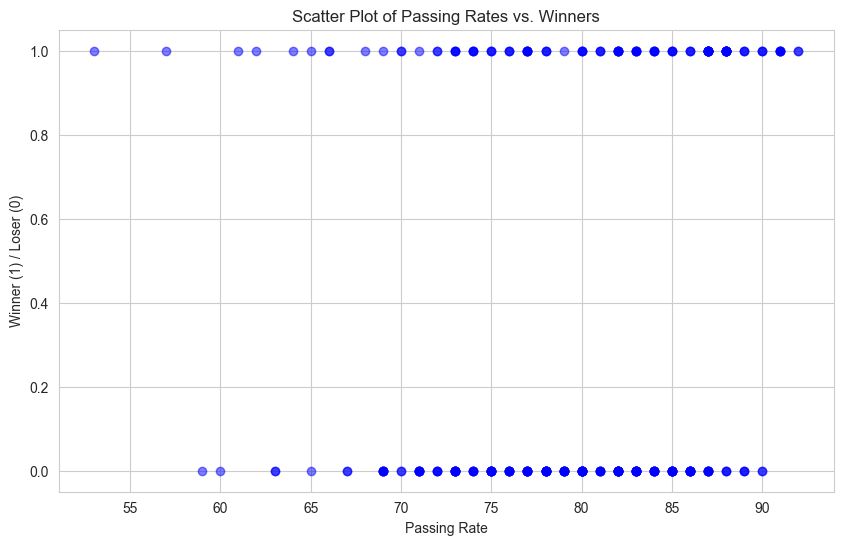

In [84]:
import matplotlib.pyplot as plt

passing_rates = passes_df.select("passing_quote").toPandas()["passing_quote"]
winners = passes_df.select("winner").toPandas()["winner"]

plt.figure(figsize=(10, 6))

plt.scatter(passing_rates, winners, color='blue', alpha=0.5)

plt.title("Scatter Plot of Passing Rates vs. Winners")
plt.xlabel("Passing Rate")
plt.ylabel("Winner (1) / Loser (0)")

plt.grid(True)
plt.show()


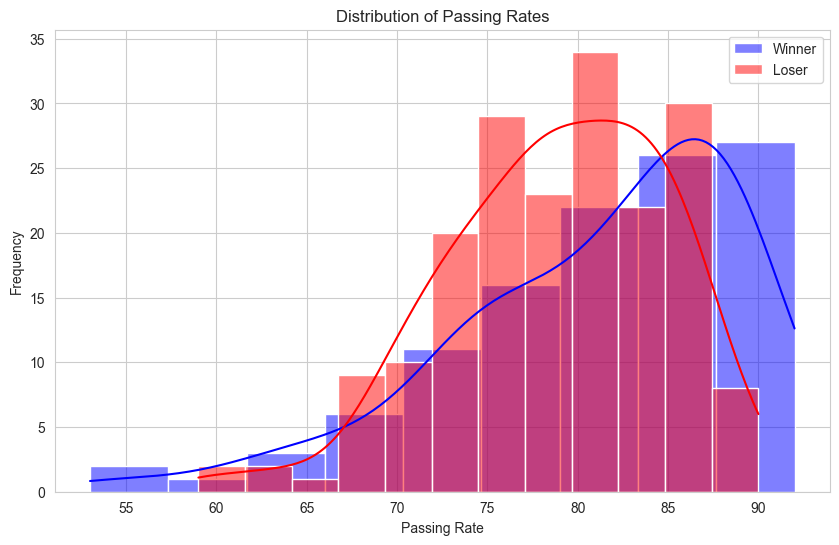

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


winner_passing_rates = passes_df.filter(passes_df["winner"] == 1).select("passing_quote").toPandas()["passing_quote"]
loser_passing_rates = passes_df.filter(passes_df["winner"] == 0).select("passing_quote").toPandas()["passing_quote"]

plt.figure(figsize=(10, 6))

sns.histplot(winner_passing_rates, kde=True, color='blue', label='Winner')

sns.histplot(loser_passing_rates, kde=True, color='red', label='Loser')

plt.title("Distribution of Passing Rates")
plt.xlabel("Passing Rate")
plt.ylabel("Frequency")
plt.legend()
plt.show()


C:\Users\Seif\AppData\Local\Temp\ipykernel_15140\1510455560.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="winner", y="passing_quote", data=passes_df.toPandas(), palette=["blue", "red"])


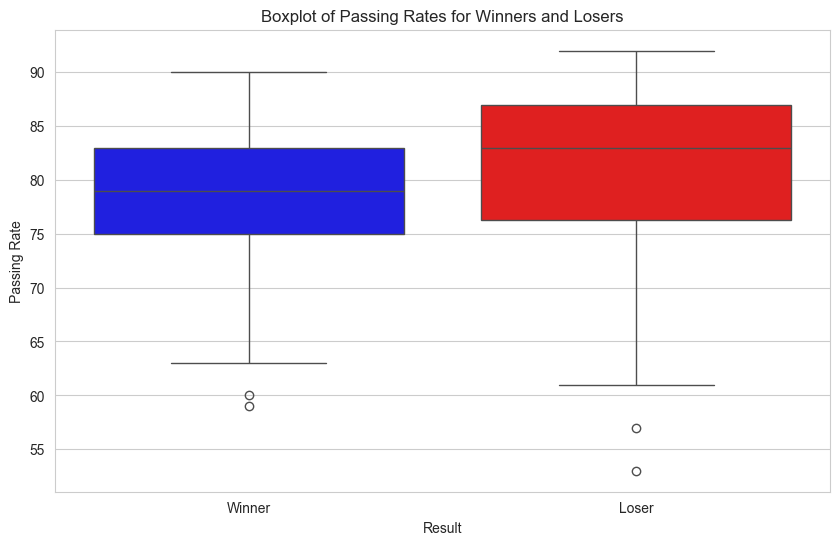

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

winner_passing_rates = passes_df.filter(passes_df["winner"] == 1).select("passing_quote").toPandas()["passing_quote"]
loser_passing_rates = passes_df.filter(passes_df["winner"] == 0).select("passing_quote").toPandas()["passing_quote"]

plt.figure(figsize=(10, 6))

sns.boxplot(x="winner", y="passing_quote", data=passes_df.toPandas(), palette=["blue", "red"])

plt.title("Boxplot of Passing Rates for Winners and Losers")
plt.xlabel("Result")
plt.ylabel("Passing Rate")
plt.xticks([0, 1], ["Winner", "Loser"])
plt.show()


In [87]:
selected_columns = ["passing_quote", "winner"]

passes_df = passes_df.filter(passes_df["passing_quote"].isNotNull())

correlation = passes_df.select(selected_columns).corr("passing_quote", "winner")

print("Correlation coefficient between passing_quote and winner:", correlation)

Correlation coefficient between passing_quote and winner: 0.15584525782767378


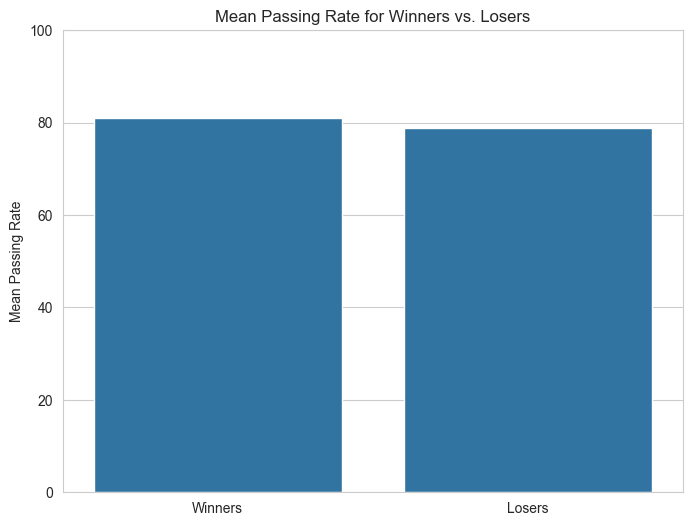

T-statistic: 2.741802595638678
P-value: 0.006474765088259819


In [89]:
mean_passing_rate_winners = passes_df.filter(passes_df["winner"] == 1).agg({"passing_quote": "mean"}).collect()[0][0]
mean_passing_rate_losers = passes_df.filter(passes_df["winner"] == 0).agg({"passing_quote": "mean"}).collect()[0][0]


plt.figure(figsize=(8, 6))
sns.barplot(x=["Winners", "Losers"], y=[mean_passing_rate_winners, mean_passing_rate_losers])
plt.title("Mean Passing Rate for Winners vs. Losers")
plt.ylabel("Mean Passing Rate")
plt.ylim(0, 100)
plt.show()


t_statistic, p_value = ttest_ind(passing_rates_winners, passing_rates_losers)
print("T-statistic:", t_statistic)
print("P-value:", p_value)

